## A Deep Learning Blitz with Pytorch 

In this notebook, we are going to look at a machine learning framework called [`PyTorch`](pytorch.org) and how it can help us train and evaluate neural networks.


## Why PyTorch

<img src="https://cdn-images-1.medium.com/max/1600/1*5PLIVNA5fIqEC8-kZ260KQ.gif" alt="dgraph" width=500 height=400/>

PyTorch provides two things out of the box:
- Dynamic Graphs: A graph that is constructed _on demand_ 
- Clean integration with Python

## Getting Data Ready 

We've imported our modules, now we begin with the first step in any deep learning application - getting data. We shall use CIFAR-10 as our example dataset. PyTorch provides direct downloads for the dataset as well as facilities for loading it out of the box. We shall take advantage of that fact. 

There are two _subsets_ in any dataset. If not done for us, we usually split our datasets into 2 categories:
- Training Set: The set of images/data which are shown during the training phase
- Validation Set: The set of images/data which are shown during the validation phase. 

In [1]:
## necessary imports 

%matplotlib inline 

import os 
import torch 
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim
import torchvision 
import torchvision.transforms as transforms
import torchvision.datasets as dsets 
import torch.utils.data as data
import numpy as np

import matplotlib.pyplot as plt 


In [2]:
# Define some transforms to the images
cifar_train_transforms = transforms.Compose([
    transforms.RandomCrop(32, padding=4), # present random crops of the input image 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])
cifar_transform = transforms.Compose([
     transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)) 
])


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# get train/val datasets
train_set = dsets.CIFAR10(root='./data_cifar10', train=True, download=True, transform=cifar_transform)
val_set = dsets.CIFAR10(root='./data_cifar10', train=False, download=True, transform=cifar_transform)


# convert that into a 'loader'
train_loader = data.DataLoader(train_set, batch_size=4, shuffle=True, num_workers=2)
val_loader = data.DataLoader(val_set, batch_size=4, shuffle=False, num_workers=2)


Files already downloaded and verified
Files already downloaded and verified


For fun, let's go ahead and show some image in our training set. We shall also see some of the classes as well. 
 

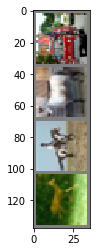

truck horse horse deer


Process Process-1:
Process Process-2:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/Users/ankitkulshrestha/anaconda3/envs/ai/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/ankitkulshrestha/anaconda3/envs/ai/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/Users/ankitkulshrestha/anaconda3/envs/ai/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ankitkulshrestha/anaconda3/envs/ai/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ankitkulshrestha/anaconda3/envs/ai/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.get()
  File "/Users/ankitkulshrestha/anaconda3/envs/ai/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 52, in _worker_loop
    r = index_queue.

In [3]:
def imshow(im_tensor):
    """
    show an input tensor 
    as an image
    """
    img = im_tensor/2 + 0.5 
    img = img.cpu().numpy()
    plt.imshow(np.transpose(img, (2,1,0)))
    plt.show() 
    

# grab some images from our training set 
d_iter = iter(train_loader)

img, labels = d_iter.next()
imshow(torchvision.utils.make_grid(img))
print(' '.join(classes[labels[j]] for j in range(4)))

Sweet, we've set up our data loaders and seen some images. Note that the `batch_size` parameter controls how many images are loaded at a time. If it's set to $1$ then only one image is loaded at a time. Usually, a big `batch_size` decreases training time since:

$$
 num\_imgs = len(dataset)/batch\_size
$$

But, you can't make `batch_size` too big since the data may not fit on your processing device.

## Convolutional Neural Networks 

![](assets/cnn.png) 


We are now going to look at different elements in a CNN and the associated PyTorch code for these elements. 

### Convolutional Layer 

<img src="https://cufctl.github.io/creative-inquiry/assets/img/convolution.gif" alt="convolution" width=300/>


This gif is basically an example of what a convolutional layer does. It takes in an image $I$ and a filter $W$ and computes a _weighted_ sum of an area equal to the filter height $F_{H}$ and width $F_{W}$. In PyTorch and other libraries, convolution is generally implemented as a depth convolution i.e. the convolution operation is applied _simultaneously_ to all the channels in the image. 

<img src="http://cs231n.github.io/assets/cnn/depthcol.jpeg" alt="depthcol" width=300/> 



In [4]:
## a convolutional layer in code 

in_size = 3
out_size = 32 
ksz= 3

conv1 = nn.Conv2d(in_channels=in_size, out_channels=out_size, kernel_size=ksz, stride=1, padding=0, bias=False)

### ReLU and MaxPool

<img src="http://cs231n.github.io/assets/nn1/relu.jpeg" alt="relu" width=300/>

The secret of power of _any_ neural networks is a non linearity. The ReLU is a simple yet very effective non-linearity that applies a thresholding operation to the output and prevents it from going negative like so:

$$
 Relu(x) = max(0,x)
$$


<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" alt="relu" width=300/>

MaxPooling operation is another operation that is used to take the maximum value in a pre-determined window. If $HxW$ was the input to a max-pool layer then it produces an output of $H/sz\ x\ W/sz$. Usually, $sz=2$ which means that the output size is half of the input size.

In [5]:
## Relu and MaxPool 
relu = nn.ReLU(inplace=True)
max_pool = nn.MaxPool2d(kernel_size=2, stride=2)

### Building a CNN in PyTorch

We'll finally look at an example of how to build a full network in PyTorch. Then we shall setup a training and evaluation routine to evaluate our network on our test dataset. 

In [18]:
class ToyCNN(nn.Module):
    """
    A toy CNN to work with the CIFAR-10 dataset
    
    Args:
    num_classes: The number of classes to predict accross
    """
    def __init__(self, num_classes=10):
        super(ToyCNN, self).__init__()
        self._ksize = 3
        self._num_channels = 32 
        self.conv1 = nn.Conv2d(3, self._num_channels, self._ksize, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(self._num_channels)
        self.conv2 = nn.Conv2d(self._num_channels, self._num_channels*2, self._ksize, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(self._num_channels*2)
        self.conv3 = nn.Conv2d(self._num_channels*2, self._num_channels*4, self._ksize, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(self._num_channels*4)
        self.conv4 = nn.Conv2d(self._num_channels*4, self._num_channels*4, self._ksize, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(self._num_channels*4)
        # the features of the last convnet layer after pooling is self._num_channels*4*4*4 (32->16->8->4)

        self.fc1 = nn.Linear(4*4*self._num_channels*4, self._num_channels*4) 
        self.fc2 = nn.Linear(self._num_channels*4, 10)
        self.dropout_rate = 0.5
                

    def forward(self, x):
        x = self.bn1(self.conv1(x)) # 32x32    
        x = F.relu_(F.max_pool2d(x, 2)) # 16x16      
        x = self.bn2(self.conv2(x)) #16x16    
        x = F.relu_(F.max_pool2d(x, 2)) # 8x8      
        x = self.bn3(self.conv3(x)) # 8x8     
        x = F.relu_(F.max_pool2d(x, 2)) # 4x4 
        x = F.relu_(self.bn4(self.conv4(x)))
        x = x.view(-1, 4*4*self._num_channels*4)
        
        if self.dropout_rate > 0 :
            x = F.dropout(F.relu(self.fc1(x)), p=self.dropout_rate, training=self.training)
        else:
            x = F.relu_(self.fc1(x))
        return self.fc2(x)

    
### lets print our network
toynet = ToyCNN(10)
print(toynet)
        

ToyCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=2048, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


### Training a network

So far, we've gathered our data and built our network. We now have all the ingredients to train our network. In PyTorch there is a concept of a _Variable_ that encapsulates the _state_ of all the layers in the network. Thus we don't have to worry about computing things at different places. All the computation is handled in the Variable class.

In [19]:
from torch.autograd import Variable


def train(net, loader, optimizer, loss_fn, num_epochs=2):
    """
    Train a network using PyTorch. 
    """
    net.train() 
    train_loss = 0.0
    for ep in range(num_epochs):
        for i, (data, labels) in enumerate(loader):
            if torch.cuda.is_available():
                data, labels = data.cuda(), labels.cuda()
            # convert the tensors to variables 
            data, labels = Variable(data), Variable(labels)  
            # pass the data 
            out = net(data)
            loss = loss_fn(out, labels)     
            optimizer.zero_grad()
            loss.backward() 
            optimizer.step() 
            
            # prints to see the loss             
            train_loss += loss.item()
            if i % 100 == 0:
                print("{}/{}: {}".format(i+1, ep+1, train_loss/100))
                train_loss = 0.0 # refresh after every 100 minibatches 


In [ ]:
## training our toy net 
optimizer = optim.Adam(toynet.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
train(toynet, train_loader, optimizer, loss_fn)
        

### Evaluating Networks 

Once our network is trained, we are interested in finding out how it actually performs on _unseen_ data. This is the reason why neural networks have been so popular. They are able to learn from limited data and _generalize_ it to vastly different data. We shall now look at ways to do so. 



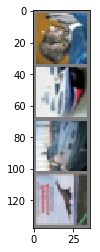

True Labels:cat ship ship plane 
Predicted:cat ship ship plane 


In [21]:
# visual check to see if we got some predictions right 

titer = iter(val_loader)
data, labels = titer.next()
imshow(torchvision.utils.make_grid(data)) 

print('True Labels:{} '.format(' '.join(classes[labels[j]] for j in range(4))))

# let's predict some data 
out = toynet(data)
_, pred = torch.max(out, 1)

print("Predicted:{} ".format(' '.join(classes[labels[j]] for j in range(4))))


In [24]:
## evaluating overall accuracy

def eval_net(net, loader, loss_fn):
    net.eval()
    total = 0
    correct = 0.0 
    
    with torch.no_grad():
        for data in loader:
            imgs, label = data 
            output = net(imgs)
            _, preds = torch.max(output.data, 1)
            
            total += label.size(0)
            correct += (preds == label).sum().item()
    
    print("{}/{}, acc:{}".format(correct, total, correct/total))
    

loss_fn = nn.CrossEntropyLoss()
eval_net(toynet, val_loader, loss_fn)
        
        
        

6432.0/10000, acc:0.6432
